# csgocrashedge

In [3]:
from decimal import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.optimize import fsolve

In [4]:
data = []  # contains list of data points

# extracts data from input.txt into a list, removes first line since element doesn't follow form
f = open('./input.txt', "r")
getcontext().prec = 4
data = f.readlines()
del data[0]
f.close()

# converts data into list of floats rather than strings
float_data = []
for line in data:
    if line == data[len(data) - 1]:
        continue
    float_data.append(float(line.split(" ")[2].split("\n")[0]))
data = float_data

In [5]:
dat = np.array(data)
df_data = pd.DataFrame(data)
df_data.rename(columns={0:'results'}, inplace=True)
df_data.describe()
# crashes that immediately occur and the gambler loses regardless of their exit time are labeled as '0' in the original data which is equivalent to '1'
df_data.loc[df_data['results'] == 0] = 1


In [6]:
# Cumulative distribution function of a Pareto Distribution
def func(x):
    return 1-1/x

# Probability distribution function of a Pareto Distribution
def pdf_func(x):
    return 1/x

(1.0, 10.0)

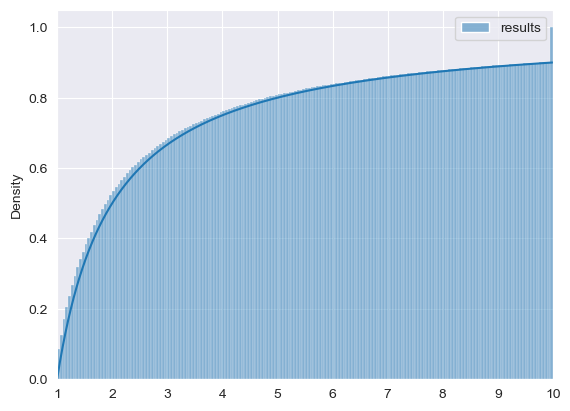

In [7]:
cut_data = df_data.copy(deep=True)
# Apply upper limit so that the histogram doesn't stretch out too much
cut_data.loc[df_data['results'] > 10] = 10

sns.histplot(cut_data, kde=False, cumulative=True, stat='density', binwidth=0.05)
plt.plot(np.arange(1, 10, 0.01), func(np.arange(1, 10, 0.01)))
plt.xlim(1, 10)

Here I have plotted the cumulative distribution function of the gambling data with a histogram, along with the CDF of a Pareto distribution with x_min=1 and alpha=1. I chose to manipulate the data such that every value above 10 is set to 10 in order for it to fit into the histogram. This prevents the graph from stretching to the point where it becomes unreadable.

Notice how the histogram of the crash data lies slightly above the Pareto distribution curve. This would be typical for the results of a game of chance with a slight house edge, as the curve represents the percent of values in the data that lie below the specified x value. Let's reduce the domain of the graph to observe this difference closer.

(1.0, 4.0)

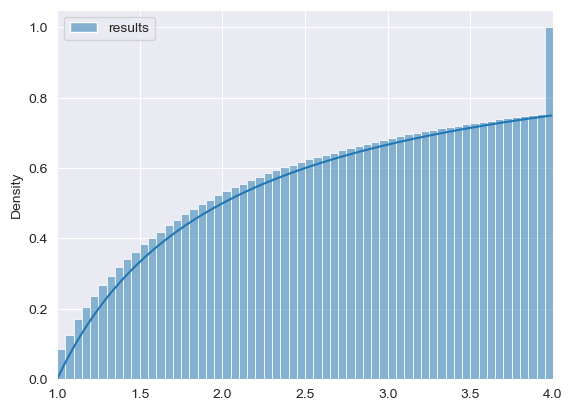

In [8]:
# Apply upper limit so that the histogram doesn't stretch out too much
cut_data.loc[df_data['results'] > 4] = 4

sns.histplot(cut_data, kde=False, cumulative=True, stat='density', binwidth=0.05)
plt.plot(np.arange(1, 4, 0.01), func(np.arange(1, 4, 0.01)))
plt.xlim(1, 4)

The differences in the two curves appear much more obvious now right? But how do we know whether is this due to a purposefully added house edge or just noise? We will determine this by performing the Anderson Darling Test on the data with a Pareto distribution.

In [9]:
# Creating the ECDF of the data sample
def data_ecdf(x):
    return np.count_nonzero(dat[dat < x])/len(dat)

ecdf = []
for x in np.arange(1, 10, 0.01):
    ecdf.append(data_ecdf(x))

(1.0, 10.0)

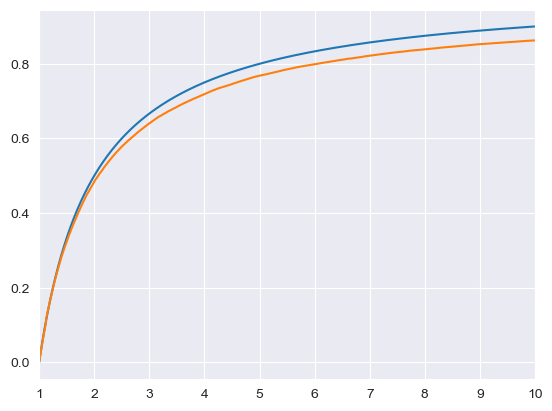

In [10]:
# Plot of ECDF vs Pareto CDF
plt.plot(np.arange(1, 10, 0.01), func(np.arange(1, 10, 0.01)))
plt.plot(np.arange(1, 10, 0.01), ecdf)
plt.xlim(1, 10)

In [11]:
copied_data = dat.copy()
copied_data = np.sort(copied_data)

# Calculating each term in S for the AD test statistic A^2 = -N - S
data_size = len(copied_data)

# In order to prevent a divide by zero error when taking the log, we must adjust all values of 1 to be minutely higher
copied_data[copied_data <= 1] = 1.000001

S = np.empty(data_size)
for i in range(data_size):
    if copied_data[i] == 0 or copied_data[data_size - i - 1] == 0: break
    S[i] = (2*i)/data_size*(np.log(func(copied_data[i])) + np.log(1-func(copied_data[data_size-i-1])))

A_squared = -data_size - np.sum(S)
print(A_squared)


1313.0242330295223


From the sheer size of the test statistic, it is clear that the Pareto distribution function by itself was not used to generate the gambling data. Instead, we will assume that the probability distribution is a generalized Pareto distribution with shape $\xi$ as follows
$$
F(x | \xi) = (\xi x)^{-\frac{\xi +1}{\xi}}
$$
Since we are assuming that the data is independent and identically distributed, we can use the Maximum Likelihood Estimation (MLE) method to find the likeliest value for $\xi$.

First lets define the likelihood function:
$$
L(\xi | x_n) = \prod_{i=1}^{n} F(x_i | \xi) = \prod_{i=1}^{n} (1+\xi x_i)^{-\frac{\xi +1}{\xi}}
$$

We can then simplify this by using the log-likelihood function:
$$
l(\xi | x_n) =  -\frac{\xi +1}{\xi}(n\ln \xi + n + \sum_{i=1}^{n} \ln x_i)
$$

We can then compute the derivative in terms of $\xi$ to be
$$
\frac{l(\xi | x_n)}{d\xi} = -n\frac{\xi - \ln \xi + 1}{\xi^2} + \frac{1}{\xi^2} \sum_{i=1}^{n} (x_i) + \frac{n}{\xi^2} = \frac{1}{\xi^2}(-n\xi + n\ln\xi + n + \sum_{i=1}^{n} (x_i))
$$
We now want to find an $\xi$ such that the log-likelihood reaches a global maximum. Since this is our goal, we can ignore $\frac{1}{\xi^2}$ within the derivative as it does not change the sign of the function.
$$
-n\xi + n\ln\xi + n + \sum_{i=1}^{n} (x_i)
$$
Now notice two properties of the new function. First, since every value of $x_i$ is greater than or equal to 1, the latter two terms in the function sum up to be positive. Second, the derivative of the first two terms equals $-n + n/\xi$, implying that the function is decreasing as $\xi$ increases for all values of $\xi > 1$. Hence the global maximum of the log-likelihood function occurs at the only $\xi$ such that the derivative in terms of $\xi$ equals 0.

In [12]:
# generalized Pareto distribution given a shape
def pareto(x, xi):
    return np.power(1+xi*x, -(xi+1)/xi)

# log-likelihood of a certain shape (xi) given points of data
def log_likelihood(x, xi):
    return np.sum(np.log(pareto(x, xi)))

# Note in the above functions are written to allow for vectorized operations

# derivative of log-likelihood in terms of xi with the first term removed
def deriv_log_likelihood_truncated(x, xi):
    return -len(x)*xi + len(x) * np.log(xi) + len(x) + np.sum(x)

In [13]:
def func(xi):
    return deriv_log_likelihood_truncated(dat, xi)

best_xi = fsolve(func, np.array([1.2]))
print(best_xi)

[16.7599113]


(1.0, 4.0)

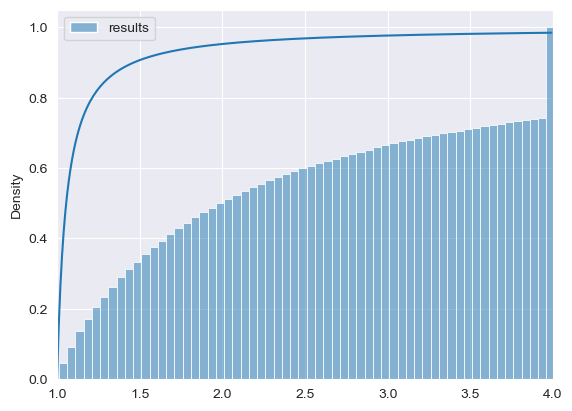

In [14]:
def cumulative_pareto(x, xi):
    return 1 - np.power(1+xi*(x-1), -(xi +1)/xi)

sns.histplot(cut_data, kde=False, cumulative=True, stat='density', binwidth=0.05)
plt.plot(np.arange(1, 4, 0.01), cumulative_pareto(np.arange(1, 4, 0.01), best_xi))
plt.xlim(1, 4)

Well then..., that's not what I expected. From this we can see that the site modified the Pareto distribution in a way which does not alter its provided parameters. Instead, lets see if there exists data which is not generated in the distribution but instead placed in artificially. The most obvious feature of raw data which could derive from this is the large amount of zeroes which are almost never supposed to be generated naturally.

In [15]:
print(np.count_nonzero(dat == 0))
print(len(dat))
print(np.count_nonzero(dat == 0) / len(dat))

1839
46549
0.03950675632129584


We can see that almost 4% of every crash (the equivalent of a slot machine spin for this game), is guaranteed to return nothing for anyone. Now let's see what happens when we remove all zeroes from the data.

In [31]:
copied_data = dat.copy()
copied_data = np.sort(copied_data)
# Calculating each term in S for the AD test statistic A^2 = -N - S

def cdf_func(x):
    return 1 - 1/x

# In order to prevent a divide by zero error when taking the log, we must adjust all values of 1 to be minutely higher
copied_data = pd.DataFrame(copied_data[copied_data > 1])
copied_data = copied_data.loc[(copied_data > 1).any(axis=1)]
copied_data = np.array(copied_data).T
data_size = len(copied_data[0])
print(copied_data.shape)

S = np.empty(data_size)
for i in range(data_size):
    if copied_data[0][i] <= 1 or copied_data[0][data_size - i - 1] <= 1: break
    # print(copied_data[0][i])
    # print(cdf_func(copied_data[0][i]), 1-cdf_func(copied_data[0][data_size-i-1]))
    S[i] = (2*i)/data_size*(np.log(cdf_func(copied_data[0][i])) + np.log(1-cdf_func(copied_data[0][data_size-i-1])))

A_squared = -data_size - np.sum(S)
print(A_squared)


(1, 44260)
0.00990099009900991 1.4802030246507947e-05
0.00990099009900991 1.8257597168780393e-05
0.00990099009900991 6.703949564845768e-05
0.00990099009900991 9.349796454927173e-05
0.00990099009900991 0.00012317349109391973
0.00990099009900991 0.00012337530149841847
0.00990099009900991 0.0001528551819435231
0.00990099009900991 0.00015972935458163917
0.00990099009900991 0.0001643939207127687
0.00990099009900991 0.00018052170773530385
0.00990099009900991 0.00020001640134492682
0.00990099009900991 0.00021681438953735643
0.00990099009900991 0.0002812662607056815
0.00990099009900991 0.0003089957945672239
0.00990099009900991 0.0003092978012019243
0.00990099009900991 0.0003184297591716234
0.00990099009900991 0.0003269843864955879
0.00990099009900991 0.0003668432405464772
0.00990099009900991 0.0003829011655511749
0.00990099009900991 0.0003922537725006281
0.00990099009900991 0.0004080433505255776
0.00990099009900991 0.00041315143652753683
0.00990099009900991 0.00042058158020907843
0.00990099009

holy shit it worked

In [17]:
# generalized Pareto distribution given a shape
# @Variables
#----------------------------
# x - Input to function
# params:
#   first element - shape
#   second element - horizontal translation of x
def pareto_adjusted(x, params):
    return np.power(1+params[0]*(x-params[1]), -(params[0]+1)/params[0])

# log-likelihood of a certain shape (xi) given points of data
def log_likelihood(x, params):
    return np.sum(np.log(pareto_adjusted(x, params)))

# Note in the above functions are written to allow for vectorized operations

# derivative of log-likelihood in terms of xi with the first term removed
def deriv_log_likelihood_truncated(x, params):
    return -len(x)*params[0] + len(x) * np.log(params[0]) - len(x) + np.sum(x)

In [18]:
def func(xi):
    return deriv_log_likelihood_truncated(dat, xi)

best_xi = fsolve(func, np.array([1.2, 0.03]))
print(best_xi)

TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'func'.Shape should be (2,) but it is (1,).